In [1]:
%matplotlib inline
import importlib.util

In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
from datetime import datetime

In [3]:
spec = importlib.util.spec_from_file_location("PandasRepo", "/Users/dennis/PycharmProjects/IbTrader/ibtrader/PandasRepo.py")
PandasRepoModule = importlib.util.module_from_spec(spec)
spec.loader.exec_module(PandasRepoModule)

In [4]:
class SectorRotationStrategy(bt.Strategy):

    def __init__(self,
                 fastSmaDays = 40,
                 slowSmaDays = 200):
        self.maxNumPositions = 6
        self.momentum = dict()
        for symbol in self.getdatanames():
            data = self.getdatabyname(symbol)
            smaFast = bt.ind.SMA(data, period=fastSmaDays)
            smaSlow = bt.ind.SMA(data, period=slowSmaDays)
            self.momentum[symbol] = smaFast/smaSlow

    def next(self):
        momentums = dict()
        for symbol in self.getdatanames():
            momentums[symbol] = self.momentum[symbol][0]

        buyThreshold = sorted(momentums.values())[-min(self.maxNumPositions, len(momentums))]
        symbolsToBuy = {k: v for k, v in momentums.items() if v >= buyThreshold}
        pct = 1.0 / len(symbolsToBuy)

        for symbol in self.getdatanames():
            if symbol in symbolsToBuy:
                self.order_target_percent(data=self.getdatabyname(symbol), target=pct)
            else:
                self.order_target_percent(data=self.getdatabyname(symbol), target=0)

In [5]:
class BacktraderWrapper:
    def __init__(self,
                 startCash = 10000,
                 universe = ["IYM", "IYC", "IYK", "IYE", "IYF", "IYH", "IYR", "IYW", "IDU"],
                 startDate = datetime(2007, 1, 2),
                 endDate = datetime(2008, 12, 31)):
        self._startCash = startCash
        self._universe = universe
        self._startDate = startDate
        self._endDate = endDate

    def printSQN(self, analyzer):
        sqn = round(analyzer.sqn,2)
        print('SQN: {}'.format(sqn))
        
    def RunBackTest(self):
        # Create an instance of cerebro
        cerebro = bt.Cerebro()

        # Add our strategy
        cerebro.addstrategy(SectorRotationStrategy)

        # Add data feed
        for symbol in self._universe:
            df = PandasRepoModule.PandasRepo().GetData(symbol, self._startDate, self._endDate)
            data = bt.feeds.PandasData(dataname=df)
            cerebro.adddata(data, name=symbol)

        # Set our desired cash start
        cerebro.broker.setcash(self._startCash)

        # Set up pyfolio
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
        cerebro.addanalyzer(bt.analyzers.SQN, _name="sqn")

        # Run over everything
        results = cerebro.run()
        #cerebro.plot(style='candlestick')
        
        strat = results[0]
         #self.printSQN(strat.analyzers.sqn.get_analysis())
        

        
        pyfoliozer = strat.analyzers.getbyname('pyfolio')
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        
        benchmarkDf = df = PandasRepoModule.PandasRepo().GetData('SPY', self._startDate, self._endDate)
        benchmarkDf = benchmarkDf['Close'].pct_change().fillna(0).tz_localize(tz='UTC')
        benchmarkDf.index.name = 'index'
        
        import matplotlib.pyplot as plt
        plt.plot(returns)
        plt.show()
        
        plt.plot(benchmarkDf)
        plt.show()

        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            benchmark_rets = benchmarkDf,
            transactions=transactions,
            gross_lev=gross_lev,
            round_trips=True)

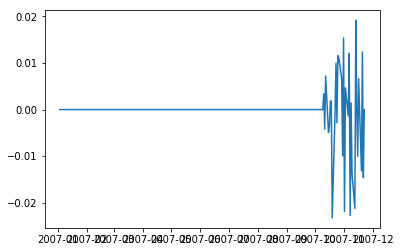

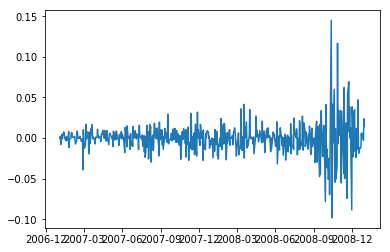

Entire data start date: 2007-01-03
Entire data end date: 2008-12-31


Backtest Months: 24


/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Performance statistics,Backtest
annual_return,nan
annual_volatility,0.07
sharpe_ratio,-0.68
calmar_ratio,nan
stability_of_timeseries,nan
max_drawdown,-0.06
omega_ratio,0.75
sortino_ratio,-0.83
skew,nan
kurtosis,nan


/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pyfolio/timeseries.py:416: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  beta, alpha = sp.stats.linregress(factor_returns.loc[ret_index].values,
/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,6.17,2007-10-31,2007-11-12,NaT,NaN
1,2.84,2007-10-12,2007-10-22,2007-10-26,11
2,0.99,2007-10-29,2007-10-30,2007-10-31,3
3,0.42,2007-10-10,2007-10-11,2007-10-12,3
4,0.00,2007-01-03,2007-01-03,2007-01-03,1




[-0.009 -0.015]


ValueError: max must be larger than min in range parameter.

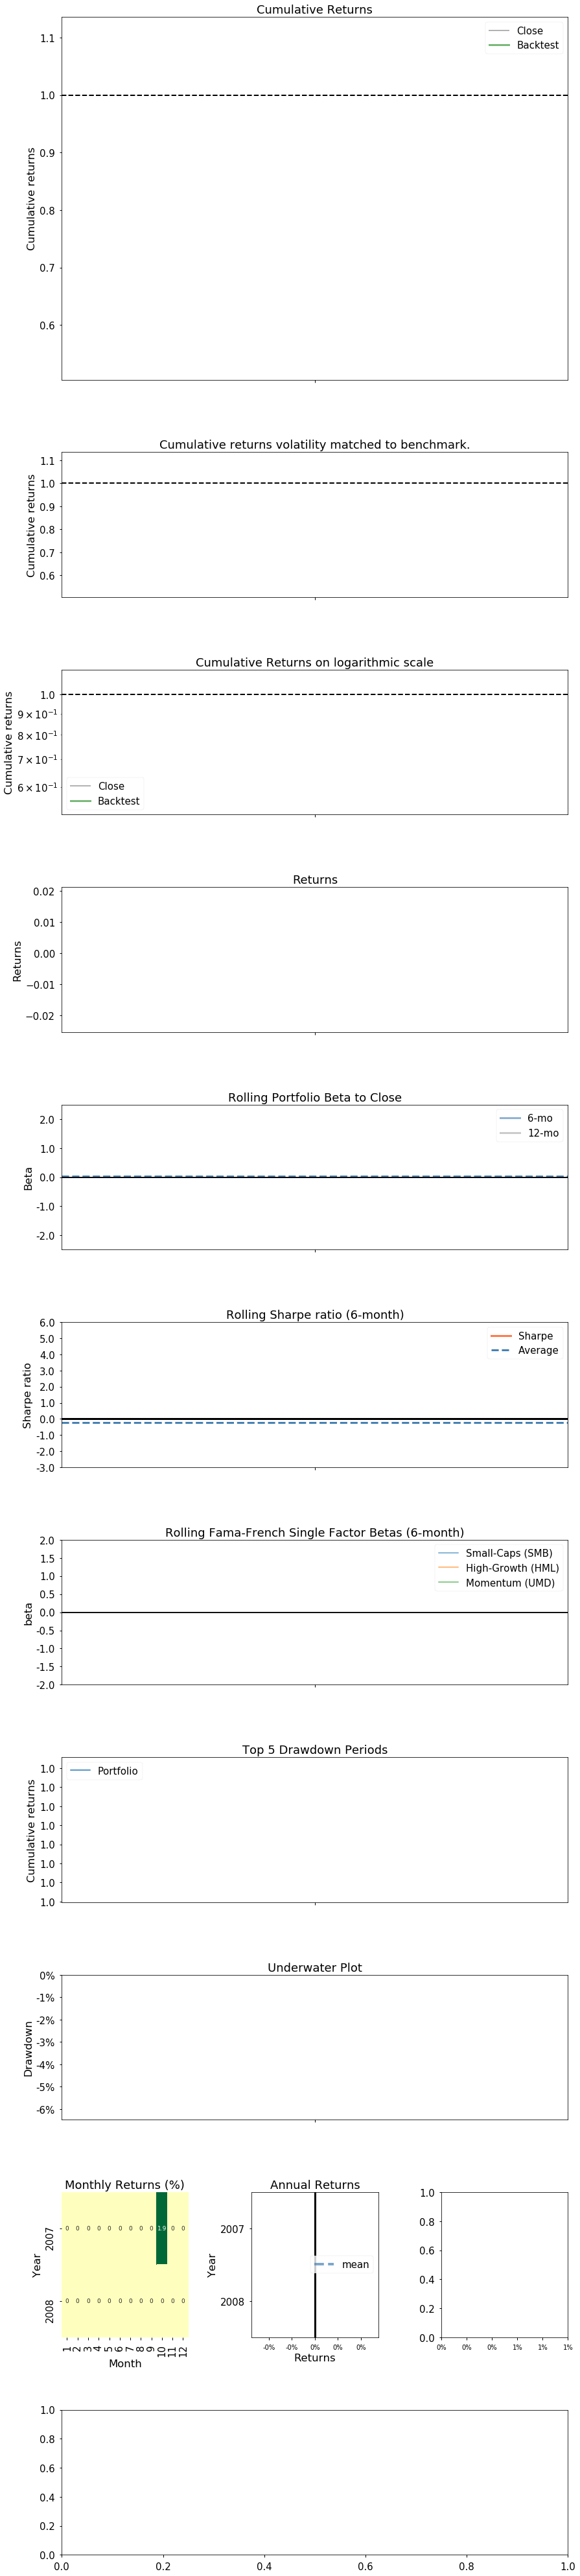

In [6]:
BacktraderWrapper(startCash=100000).RunBackTest()